In [111]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.csg import *

import scipy.sparse as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

## Convergence study for Hodge Laplace in 2D for 1-forms
- From the first implementation that ran!
- With sinusoidal manufactured solution that vanishes on the boundary

In [112]:
def hodgeLaplace2Dfor1forms(order = 1,
                            maxh = 0.1,
                            C_w = 1 ):

    mesh = Mesh(unit_square.GenerateMesh(maxh=maxh))
    fes_curl = HCurl(mesh, order=order, type1=True)  # For 1-forms, H(curl)
    fes_H1 = H1(mesh, order=order)     # For 0-forms, H1 space
    h_min_bnd = min(Integrate(1, mesh, BND, element_wise=True)) 
    prodSpc = fes_curl * fes_H1 # Product space

    # Trial and test functions assignment for product space
    omega_h, sigma_h = prodSpc.TrialFunction()
    eta_h, tau_h = prodSpc.TestFunction()

    n = specialcf.normal(mesh.dim)

    a = BilinearForm(prodSpc)
    a += sigma_h * tau_h * dx
    a += - omega_h * grad(tau_h) * dx
    a +=  grad(sigma_h) * eta_h * dx
    a +=  curl(omega_h) * curl(eta_h) * dx
    
    tr_hs_d_omega = CF(omega_h[1].Diff(x) - omega_h[0].Diff(y))
    tr_eta = CF(eta_h[1]*n[0] - eta_h[0]*n[1])
    tr_omega = CF(omega_h[1]*n[0] - omega_h[0]*n[1])
    tr_hs_d_eta = CF(eta_h[1].Diff(x) - eta_h[0].Diff(y))

    a += tr_hs_d_omega * tr_eta * ds(skeleton=True, definedon=mesh.Boundaries("bottom|right|top|left"))
    a += tr_omega * tr_hs_d_eta * ds(skeleton=True, definedon=mesh.Boundaries("bottom|right|top|left"))
    a += (C_w / h_min_bnd) * tr_omega * tr_eta * ds(skeleton=True, definedon=mesh.Boundaries("bottom|right|top|left"))

    omega_exact = CF((sin(pi*x)*sin(pi*y), sin(pi*x)*sin(pi*y)))
    div_omega = CF(omega_exact[0].Diff(x) + omega_exact[1].Diff(y))
    grad_div_omega = CF((div_omega.Diff(x), div_omega.Diff(y)))
    rot_omega = CF(omega_exact[1].Diff(x) - omega_exact[0].Diff(y))
    curl_rot_omega = CF((rot_omega.Diff(y), - rot_omega.Diff(x)))
    grad_sigma_manufactured = CF((-div_omega.Diff(x), -div_omega.Diff(y)))
    f_rhs = CF(curl_rot_omega - grad_div_omega)
    f = LinearForm(prodSpc)
    f += f_rhs * eta_h * dx

    a.Assemble()
    f.Assemble()

    rows,cols,vals = a.mat.COO()
    A = sp.csr_matrix((vals,(rows,cols)))
    #cond_nr = np.linalg.cond(A.todense()) # takes way longer than solving the system lolll..

    sol = GridFunction(prodSpc)
    res = f.vec-a.mat * sol.vec
    inv = a.mat.Inverse(freedofs=prodSpc.FreeDofs(), inverse="pardiso")
    sol.vec.data += inv * res

    gf_omega , gf_sigma = sol.components

    curl_omega = curl(gf_omega)
    grad_sigma = grad(gf_sigma)

    L2_error_omega = sqrt(Integrate((gf_omega - omega_exact)**2, mesh))
    L2_error_curl_omega = sqrt(Integrate((curl_omega - rot_omega)**2, mesh))
    L2_error_sigma = sqrt(Integrate((gf_sigma + div_omega)**2, mesh))
    L2_error_grad_sigma = sqrt(Integrate((grad_sigma - grad_sigma_manufactured)**2, mesh))

    return prodSpc.ndof, Norm(res), L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma

In [113]:
def logspace_custom_decades(start, stop, points_per_decade):
    
    result = []
    current_decade = start
    while current_decade < stop:
        decade_points = np.logspace(np.log10(current_decade), np.log10(current_decade * 10), points_per_decade, endpoint=False)
        result.extend(decade_points)
        current_decade *= 10
    return np.array(result)

In [114]:
Cw_vals = logspace_custom_decades(1, 10**4, 10)
order_cw = 2
hmax_cw = 0.025
results_cw = []

for C_w in Cw_vals:
    ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace2Dfor1forms(order=order_cw, maxh=hmax_cw, C_w=C_w)
    
    #print("solving with C_w = ", C_w)
    results_cw.append({
        'order': order_cw,
        'hmax': hmax_cw,
        'C_w': C_w,
        'ndof': ndof,
        'res': res,
        'L2_error_omega': L2_error_omega,
        'L2_error_curl_omega': L2_error_curl_omega,
        'L2_error_sigma': L2_error_sigma,
        'L2_error_grad_sigma': L2_error_grad_sigma
    })

df_cw = pd.DataFrame(results_cw)



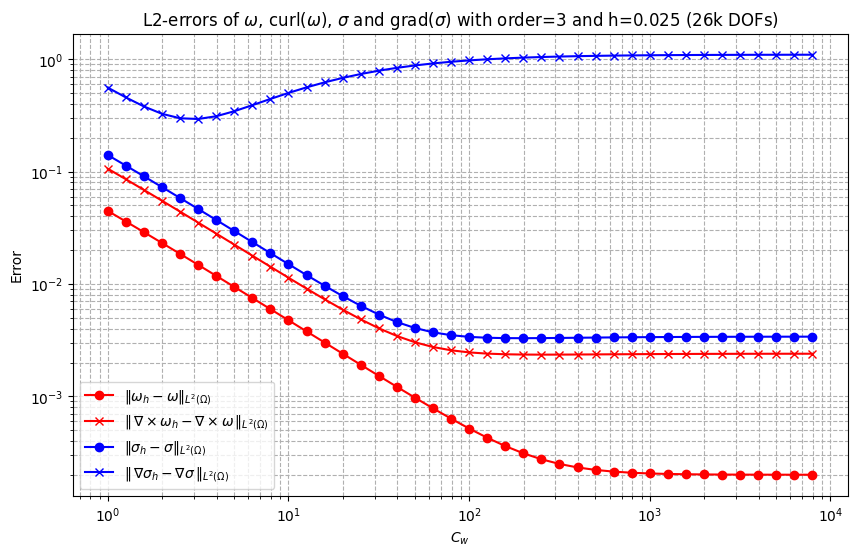

3.1622776601683795


In [115]:
plt.figure(figsize=(10, 6))

#  'L2_error_omega' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_omega'], label='L2_error_omega', marker='o', color='red')

#  'L2_error_curl_omega' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_curl_omega'], label='L2_error_curl_omega', marker='x', color='red')

#  'L2_error_sigma' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_sigma'], label='L2_error_sigma', marker='o', color='blue')

#  'L2_error_grad_sigma' vs 'C_w'
plt.plot(df_cw['C_w'], df_cw['L2_error_grad_sigma'], label='L2_error_grad_sigma', marker='x', color='blue')


plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='both', linestyle='--')

plt.xlabel('$C_w$')
plt.ylabel('Error')
plt.title('L2-errors of $\omega$, curl($\omega$), $\sigma$ and grad($\sigma$) with order=3 and h=0.025 (26k DOFs)')


plt.legend([r'$\Vert \omega_h - \omega \Vert_{L^2(\Omega)}$',
            r'$\Vert \, \nabla \times \omega_h - \nabla \times \omega \, \Vert_{L^2(\Omega)}$',
            r'$\Vert \sigma_h - \sigma \Vert_{L^2(\Omega)}$',
            r'$\Vert \, \nabla \sigma_h - \nabla  \sigma \, \Vert_{L^2(\Omega)}$'])

plt.show()

min_index = df_cw['L2_error_grad_sigma'].idxmin()
min_C_w = df_cw['C_w'][min_index]
print(min_C_w)

Data Generation for plots!

In [116]:
#Cw_vals = min_C_w
Cw_vals = 10**3

order = np.linspace(1,5,5)
maxh = [0.5, 0.4, 0.3, 0.2, 0.1, 0.09, 0.08, 0.07, 0.06, 0.05, 0.04, 0.03, 0.02, 0.01]

results = []
for hmax in maxh:
    for order_mesh in order:
        ndof, res, L2_error_omega, L2_error_curl_omega, L2_error_sigma, L2_error_grad_sigma = hodgeLaplace2Dfor1forms(order=order_mesh, maxh=hmax, C_w=Cw_vals)
        
        #print("Currently solving with h = ", hmax, " and mesh order ", order_mesh)
        results.append({
            'order': order_mesh,
            'hmax': hmax,
            'C_w': Cw_vals,
            'ndof': ndof,
            'res': res,
            'L2_error_omega': L2_error_omega,
            'L2_error_curl_omega': L2_error_curl_omega,
            'L2_error_sigma': L2_error_sigma,
            'L2_error_grad_sigma': L2_error_grad_sigma
        })

df = pd.DataFrame(results)

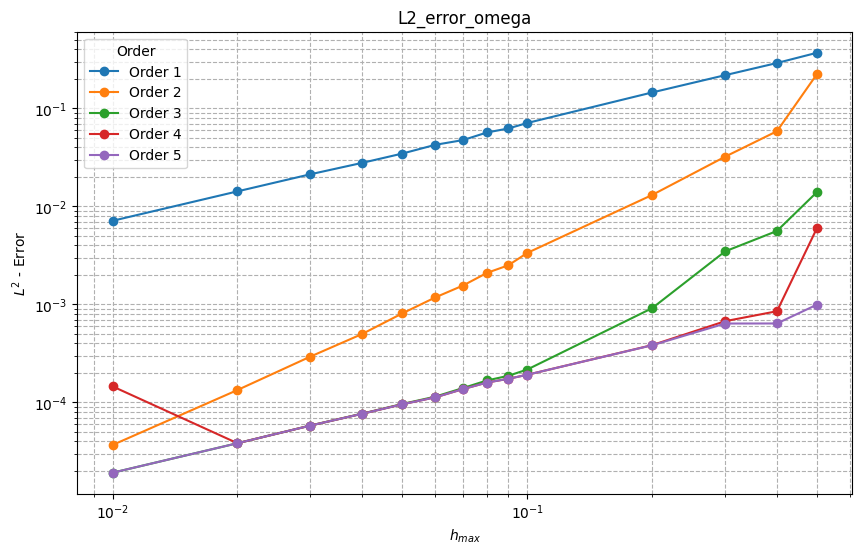

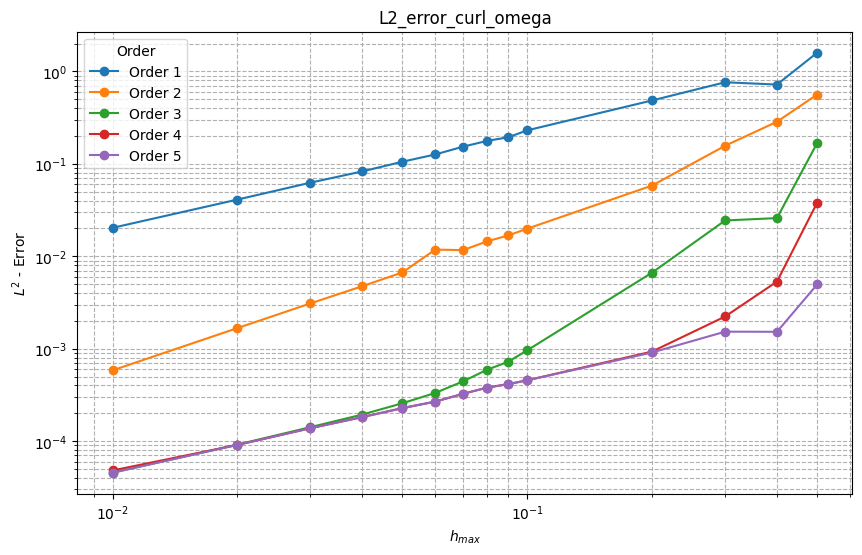

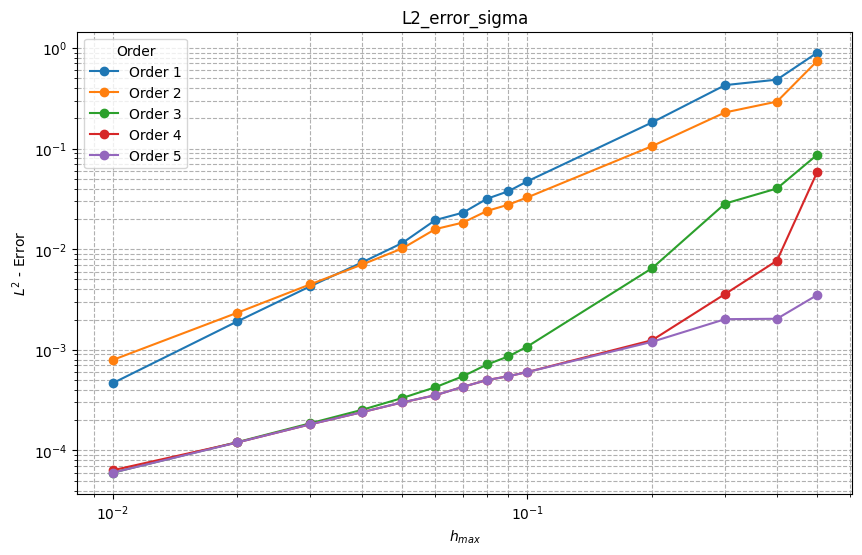

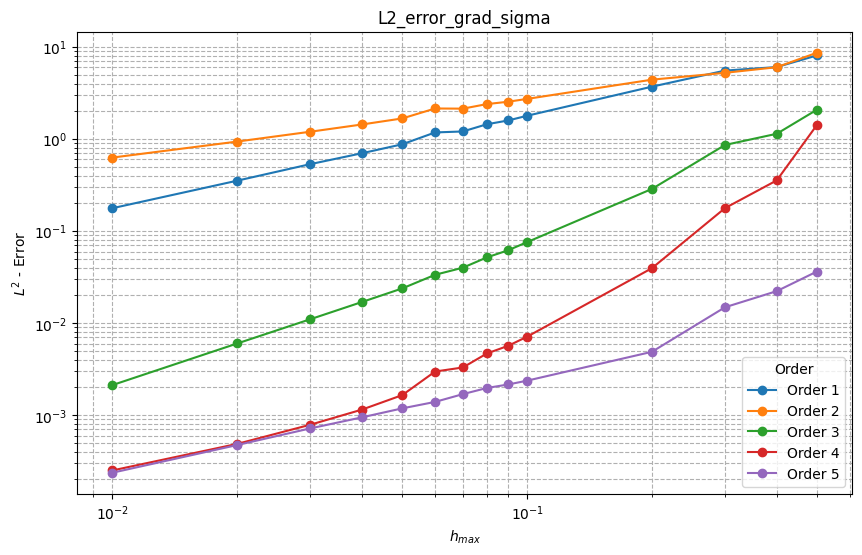

In [117]:
error_columns = ['L2_error_omega', 'L2_error_curl_omega', 'L2_error_sigma', 'L2_error_grad_sigma']

for error_col in error_columns:
    plt.figure(figsize=(10, 6)) 

    for order_mesh, group in df.groupby('order'):

        plt.plot(group['hmax'], group[error_col], label=f'Order {int(order_mesh)}', marker='o')

    plt.xscale('log')
    plt.yscale('log')

    # Set labels, title, and grid
    plt.xlabel('$h_{max}$')
    plt.ylabel(r'$L^2$ - Error')
    plt.title(f'{error_col}')
    plt.grid(True, which='both', linestyle='--')

    plt.legend(title="Order")

    plt.show()